In [12]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

In [13]:
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('trade_date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [14]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow as tf
tf.random.set_seed(4)
# from util import csv_to_dataset, history_points

In [15]:
df = pd.read_csv('data/PA_daily.csv')
df.head()

,trade_date,open,high,low,close,amount
0,20200701,12.79,13.15,12.74,13.12,2202800.843
1,20200630,12.83,12.88,12.72,12.80,1199181.601
2,20200629,12.92,12.97,12.71,12.80,1330678.288
3,20200624,12.64,12.88,12.60,12.80,1946329.095
4,20200623,12.65,12.69,12.52,12.60,1248046.646


(2081, 50, 5)
(232, 50, 5)
Epoch 1/50
59/59 [==============================] - 2s 42ms/step - loss: 0.0396 - val_loss: 6.8071e-04
Epoch 2/50
59/59 [==============================] - 1s 24ms/step - loss: 0.0036 - val_loss: 7.4944e-04
Epoch 3/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0026 - val_loss: 5.4104e-04
Epoch 4/50
59/59 [==============================] - 3s 44ms/step - loss: 0.0022 - val_loss: 6.7251e-04
Epoch 5/50
59/59 [==============================] - 1s 25ms/step - loss: 0.0020 - val_loss: 7.3975e-04
Epoch 6/50
59/59 [==============================] - 2s 26ms/step - loss: 0.0018 - val_loss: 5.4614e-04
Epoch 7/50
59/59 [==============================] - 2s 26ms/step - loss: 0.0017 - val_loss: 7.6585e-04
Epoch 8/50
59/59 [==============================] - 2s 27ms/step - loss: 0.0016 - val_loss: 3.7519e-04
Epoch 9/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 4.8641e-04
Epoch 10/50
59/59 [===========================

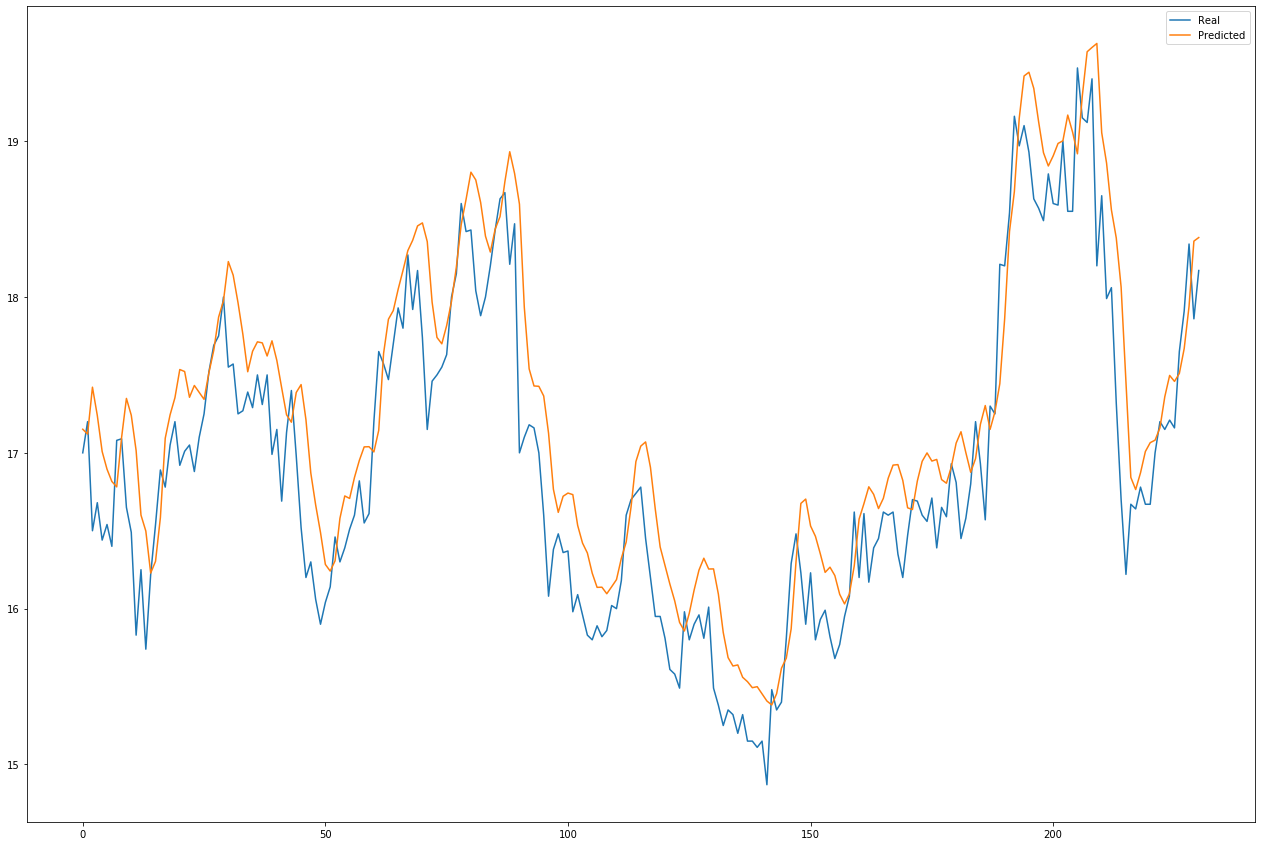

In [8]:
ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('data/PA_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'basic_model.h5')

(2081, 50, 5)
(232, 50, 5)
Epoch 1/50
59/59 [==============================] - 3s 46ms/step - loss: 0.0124 - val_loss: 0.0025
Epoch 2/50
59/59 [==============================] - 2s 29ms/step - loss: 0.0030 - val_loss: 5.4459e-04
Epoch 3/50
59/59 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 6.4105e-04
Epoch 4/50
59/59 [==============================] - 1s 24ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 5/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 4.7249e-04
Epoch 6/50
59/59 [==============================] - 1s 24ms/step - loss: 0.0017 - val_loss: 7.7059e-04
Epoch 7/50
59/59 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 5.8701e-04
Epoch 8/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 4.5240e-04
Epoch 9/50
59/59 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 6.0885e-04
Epoch 10/50
59/59 [==============================] - 2

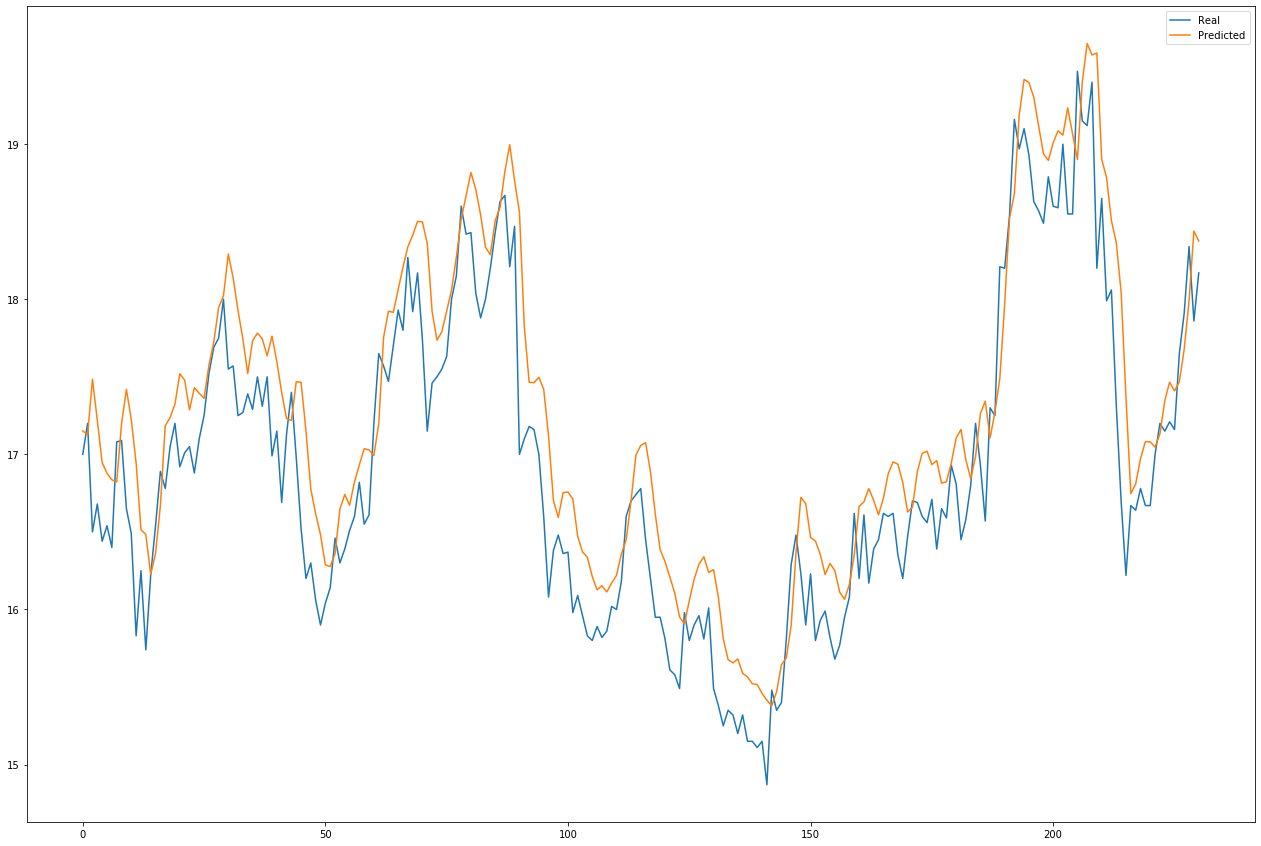

In [9]:
# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('data/PA_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')

buys: 213
sells: 1
earnings: $172.02895399556132


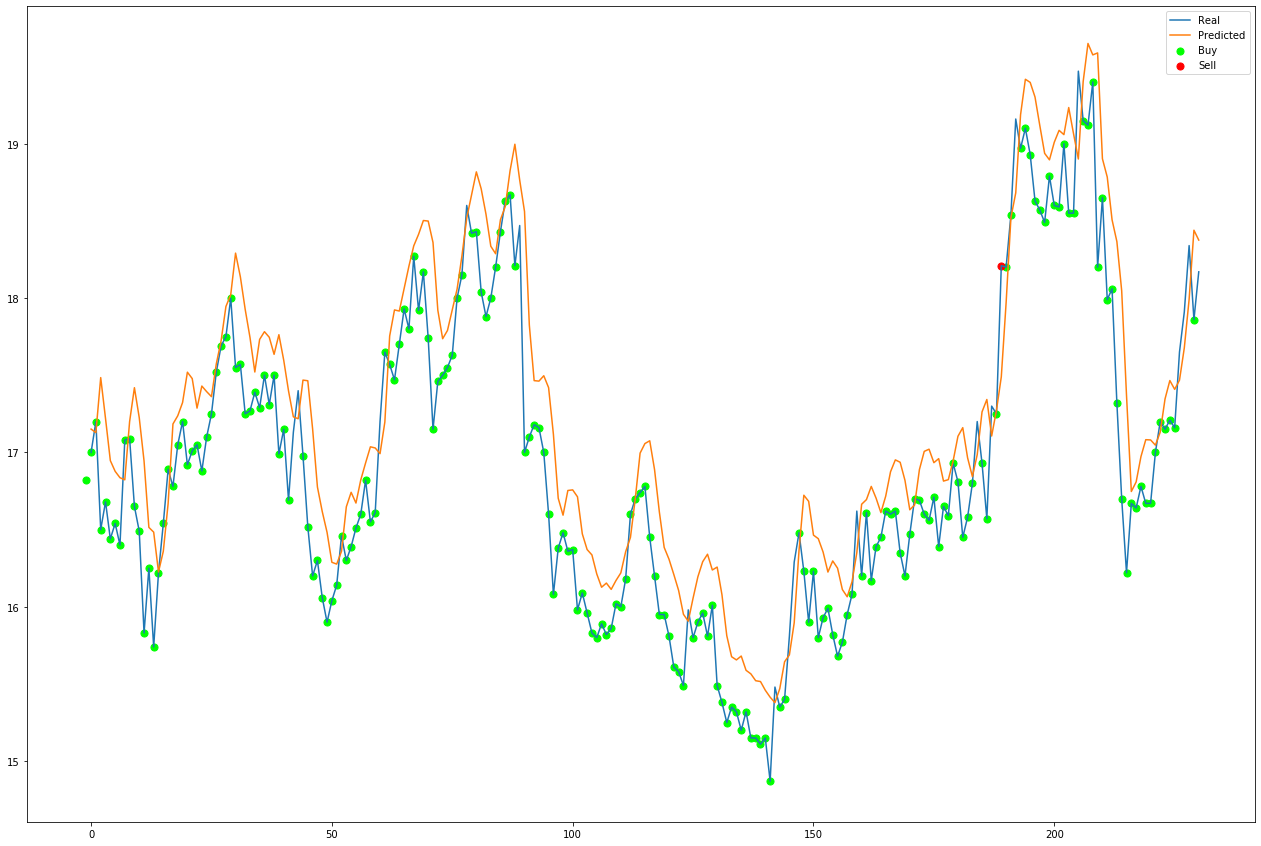

In [10]:
from keras.models import load_model

model = load_model('technical_model.h5')

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('data/PA_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

buys = []
sells = []
thresh = 0.1

start = 0
end = -1

x = -1
for ohlcv, ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)
#     model.predict([np.array([ohlcv]), np.array([ind])])
    predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([np.array([ohlcv]), np.array([ind])])))
    delta = predicted_price_tomorrow - price_today
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, price_today[0][0]))
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")


def compute_earnings(buys_, sells_):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys_) > 0 and len(sells_) > 0:
        if buys_[0][0] < sells_[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys_[0][1]
            buys_.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells_[0][1]
            stock = 0
            sells_.pop(0)
    print(f"earnings: ${balance}")


# we create new lists so we dont modify the original
compute_earnings([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()